In [20]:
import os
import sys
# add the src directory to the path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "src"))

from ttt_pyttt import PyTTT
from utils import plot_traces
import numpy as np
from matplotlib import pyplot as plt

# Example 3: Dynamic long-term memory

```mermaid
    graph TB
        set((set))
        reset((reset))
        delay1{{delay 1}}
        delay2(delay 2)
        delay3{{delay 3}}
        delay4(delay 4)
        trigger1(trigger1)
        trigger2(trigger2)
        memory(memory)

        set --> trigger2
        reset --o delay1
        reset --o delay2
        reset --o delay3
        reset --o delay4
        reset ---o memory
        
        delay1 --o trigger1
        delay2 --> trigger1

        delay3 --o trigger2
        delay4 --> trigger2

        trigger1 --> delay3
        trigger1 --> delay4

        trigger2 --> delay1
        trigger2 --> delay2

        trigger1 --> memory
        trigger2 --> memory
```
a

In [21]:
# construct model
# 7 nodes: delay 1, delay 2, trigger 1, delay 3, delay 4, trigger 2, memory
good_thresh = np.array([1, 1, 1, 1, 1, 1, 1])
bad_thresh = np.array([0, 0, 0, 0, 0, 0, 0])
W_good = np.array([
    [0, 0, 0, 0, 0, 1, 0], # delay 1
    [0, 0, 0, 0, 0, 1, 0], # delay 2
    [0, 1, 0, 0, 0, 0, 0], # trigger 1
    [0, 0, 1, 0, 0, 0, 0], # delay 3
    [0, 0, 1, 0, 0, 0, 0], # delay 4
    [0, 0, 0, 0, 1, 0, 0], # trigger 2
    [0, 0, 1, 0, 0, 1, 0]  # memory
])
W_bad = np.array([
    [0, 0, 0, 0, 0, 0, 0], # delay 1
    [0, 0, 0, 0, 0, 0, 0], # delay 2
    [1, 0, 0, 0, 0, 0, 0], # trigger 1
    [0, 0, 0, 0, 0, 0, 0], # delay 3
    [0, 0, 0, 0, 0, 0, 0], # delay 4
    [0, 0, 0, 1, 0, 0, 0], # trigger 2
    [0, 0, 0, 0, 0, 0, 0]  # memory
])

# retrigger after 100ms, the trigger-pulse itself is 10ms
interval = 100
pulse = 10
pulse_duration = np.array([interval-1, interval, pulse, interval-1, interval, pulse, interval+1])

net = PyTTT(goodThreshold=good_thresh, badThreshold=bad_thresh, W_good=W_good, W_bad=W_bad, duration=pulse_duration)


In [22]:
# generate input
num_steps = 1000
dt = 1e-3
steps = np.arange(num_steps)*dt

good_tokens_in = np.zeros((num_steps, len(good_thresh)), dtype=np.int32)
bad_tokens_in = np.zeros((num_steps, len(good_thresh)), dtype=np.int32)

# set the memory at 100ms and clear at 900ms
good_tokens_in[100, 5] = 1
bad_tokens_in[900, :] = 1

# give each input signal a duration of 1ms
PyTTT.set_expiration(good_tokens_in, 1, circular=False)

# run and keep track of the generated EPSPs, spikes and plateaus
did_start = np.zeros_like(good_tokens_in, dtype=np.int32)
did_stop = np.zeros_like(good_tokens_in, dtype=np.int32)
for step,(start_token, stop_token) in enumerate(net.run(good_tokens_in, bad_tokens_in)):
    did_start[step,:] = start_token
    did_stop[step,:] = stop_token


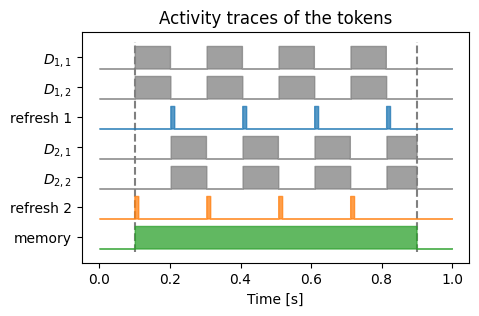

In [29]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(5, 3))
colors = ["gray", "gray", "C0", "gray", "gray", "C1",  "C2"]
labels = [r"$D_{1,1}$", r"$D_{1,2}$", "refresh 1", r"$D_{2,1}$", r"$D_{2,2}$", "refresh 2", "memory"]

ax.vlines(steps[[100, 900]], 0.5, 7.5, color="gray", linestyle="--", zorder=0)

ax.set_title("Activity traces of the tokens")
ax.set_xlabel("Time [s]")
plot_traces(steps, did_start, did_stop, ax=ax, colors=colors, labels=labels, alpha=0.75, zorder=10)

fig.savefig("memory.png", dpi=300, bbox_inches="tight")
fig.savefig("memory.svg", dpi=300, bbox_inches="tight")
fig.savefig("memory.pdf", dpi=300, bbox_inches="tight")